## Thumbnail Generation Workflow

Um den Prozess abzuschließen soll für das generierte Video noch ein passendes Thumbnail generiert werden, dass eventuell etwas interessanter aussieht als einfach eine Stelle des Videos. Dafür generiert ein Sprachmodell Ideen, die dann in Function Calls und letztlich Prompts und generierte Bilder überführt werden, von denen dann die geeigneten Bilder durch das Vision Language Model ausgewählt werden.

### Imports

In [1]:
# Diffusers Models
import torch
from diffusers import FluxPipeline, FluxTransformer2DModel, GGUFQuantizationConfig
from diffusers import StableDiffusionXLPipeline

# LlamaIndex Workflow
from llama_index.core.workflow import Event, StartEvent, StopEvent, Workflow, step, Context
from llama_index.utils.workflow import draw_all_possible_flows, draw_most_recent_execution # to visualize the Workflow

# Ollama LLM
import ollama

# Typing and Structured Output Models
from typing import List
from pydantic import BaseModel

# Utility Libraries
import json
import os
from IPython.display import Image, display # for displaying generated images

### Load Video Plan

Lade Resulte aus dem ersten Part der Pipeline.

In [2]:
# Load part 1 results (task description and video plan)
part_1_results = {}

try:
    with open('results/part_1_results.json', 'r') as f:
        part_1_results = json.load(f)
    
    task_description = part_1_results.get('task_description', None)
    video_plan = part_1_results.get('video_plan', None)
except:
    task_description = part_1_results.get('task_description', None)
    video_plan = part_1_results.get('video_plan', None)

### Thumbnail Generation Workflow Settings

In [3]:
# Thumbnail Generation Settings
thumbnail_generation_settings = {
    "project_name": "project-1",
    "diffusion_model": "shuttle",
    "code_llm": "qwen2.5-coder:latest",
    "vlm": "llama3.2-vision:latest",
    "debug_mode": True
}

### Utility Functions

In [4]:
# Function to initialize a quantized Shuttle Diffusion Pipeline
def initialize_shuttle_diffusion_pipeline():
    ckpt_path = "https://huggingface.co/shuttleai/shuttle-3.1-aesthetic/blob/main/gguf/shuttle-3.1-aesthetic-Q4_K_S.gguf"
    
    transformer = FluxTransformer2DModel.from_single_file(
        ckpt_path,
        quantization_config=GGUFQuantizationConfig(compute_dtype=torch.bfloat16),
        torch_dtype=torch.bfloat16
    ).to("cuda")
    
    pipe = FluxPipeline.from_pretrained(
        "shuttleai/shuttle-3.1-aesthetic",
        transformer=transformer,
        torch_dtype=torch.bfloat16
    ).to("cuda")
    
    return pipe

# Function to initialize a Stable Diffusion XL Pipeline
def initialize_sdxl_pipeline():

    pipe = StableDiffusionXLPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
    ).to("cuda")
    
    return pipe
    
# Initialize the pipeline
if thumbnail_generation_settings["diffusion_model"] == "shuttle":
    pipe = initialize_shuttle_diffusion_pipeline()
else:
    pipe = initialize_sdxl_pipeline()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [5]:
# Generate image tool
def generate_image(prompt: str, file_name: str):
    """
    Generates an image based on a given prompt and saves the result under the given file name

    Args:
    prompt: AI generated prompt to generate an image using a diffusion model
    file_name: Name used to save the generated without file extension

    Returns:
    str: The whole path where the image file was saved
    """
    current_folder = os.getcwd()
    output_dir = (
        current_folder + "/thumbnails/" + thumbnail_generation_settings["project_name"]
    )

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    if thumbnail_generation_settings["diffusion_model"] == "shuttle":
        num_inference_steps = 4
    else:
        num_inference_steps = 50

    height = 288 # Alternatives: 576, 720,
    width = 512 # Alternatives: 1024, 1280

    image = pipe(
        prompt,
        height=height,
        width=width,
        guidance_scale=10.0,
        num_inference_steps=num_inference_steps,
        generator=torch.manual_seed(42),
    ).images[0]

    file_path = output_dir + "/" + file_name + ".png"
    image.save(file_path)
    return file_path

In [6]:
# Ollama LLM Utility Function with optional image input, function calling and structured output generation
def call_ollama_model(
    model="qwen2.5-coder:latest",
    system_prompt=None,
    user_prompt=None,
    temperature=0.1,
    context_size=16384,
    images=None,
    tools=None,
    json_schema=None
):
    response = ollama.chat(
        model=model,
        messages=[
            {
                "role": "system",
                "content": system_prompt
            },
            {
                "role": "user",
                "content": user_prompt,
                "images": images
            }
        ],
        options={
            "temperature": temperature,
            "num_ctx": context_size
        },
        format=json_schema,
        tools=tools
    )
    
    return response.message

### Model and Event Definition

In [7]:
# Model for structured output generation of thumbnail ideas
class ThumbnailIdeas(BaseModel):
    thumbnail_ideas: List[str]

# Model for structured output generation of image suitability as thumbnail
class ImageSuitability(BaseModel):
    is_suitable: bool
    explanation: str

# Event that thumbnail ideas are generated
class ThumbnailIdeasGeneratedEvent(Event):
    thumbnail_ideas: ThumbnailIdeas

# Event that images were generated
class ImagesGeneratedEvent(Event):
    image_paths: List[str]

In [8]:
# Custom prompts for thumbnail generation workflow
import prompts.thumbnail_prompts as thumbnail_prompts

In [9]:
# Example system prompt
thumbnail_system_prompts = thumbnail_prompts.SystemPrompts()
print(thumbnail_system_prompts.THUMBNAIL_IDEA_GENERATION)


You are a professional educational YouTuber specializing in mathematical content, with over 1 million subscribers.
Your expertise includes:
- Creating visually engaging thumbnails that capture viewer attention
- Understanding what drives click-through rates in educational content
- Balancing academic rigor with visual appeal

Guidelines for thumbnail ideation:
1. Incorporate symbolic or historical elements related to mathematics
2. Use visual metaphors that connect abstract concepts to tangible objects
3. Consider incorporating:
   - Historical mathematicians' portraits or busts
   - Mathematical symbols and diagrams
   - Visual paradoxes or optical illusions
   - Sacred geometry patterns
   - Real-world applications of mathematical concepts

Avoid:
- Overly complex mathematical notation
- Direct representation of video content
- Generic stock photos without mathematical significance
- Clickbait that misrepresents the content



In [10]:
# Example user prompt
thumbnail_user_prompts = thumbnail_prompts.UserPrompts()
print(thumbnail_user_prompts.THUMBNAIL_IDEA_GENERATION)


Generate a list of {num_thumbnails} thumbnail ideas on the following topic and video plan:

Task Description: {task_description}

Video plan: {video_plan}



In [11]:
# Example user prompt params
user_prompts = thumbnail_prompts.UserPrompts()
print(user_prompts.get_params("THUMBNAIL_IDEA_GENERATION"))

['num_thumbnails', 'task_description', 'video_plan']


In [12]:
class ThumbnailGenerationFlow(Workflow):
    @step
    async def generate_thumbnail_ideas(
        self, ctx: Context, ev: StartEvent
    ) -> ThumbnailIdeasGeneratedEvent:
        # Get input and settings from StartEvent
        task_description = ev.task_description
        video_plan = ev.video_plan
        num_thumbnails = ev.num_thumbnails

        settings = ev.settings
        code_llm = settings.get("code_llm", "qwen2.5-coder:latest")
        vlm = settings.get("vlm", "llama3.2-vision:latest")
        debug_mode = settings.get("debug_mode", False)

        # Set initial global context
        await ctx.set("code_llm", code_llm)
        await ctx.set("vlm", vlm)
        await ctx.set("debug_mode", debug_mode)

        system_prompt = thumbnail_system_prompts.THUMBNAIL_IDEA_GENERATION
        user_prompt = thumbnail_user_prompts.THUMBNAIL_IDEA_GENERATION.format(
            num_thumbnails=num_thumbnails,
            task_description=task_description,
            video_plan=video_plan,
        )

        response_msg = call_ollama_model(
            model=vlm,
            system_prompt=system_prompt,
            user_prompt=user_prompt,
            images=None,
            temperature=0.1,
            context_size=16384,
            json_schema=ThumbnailIdeas.model_json_schema(),
        )

        # Try to parse the generated JSON response
        try:
            thumbnail_ideas = json.loads(response_msg.content)
        except:
            thumbnail_ideas = ThumbnailIdeas(thumbnail_ideas=[])

        if debug_mode:
            print(thumbnail_ideas)

        return ThumbnailIdeasGeneratedEvent(thumbnail_ideas=thumbnail_ideas)

    @step
    async def generate_images(
        self, ctx: Context, ev: ThumbnailIdeasGeneratedEvent
    ) -> ImagesGeneratedEvent:
        # Get input and settings from ThumbnailIdeasGeneratedEvent
        thumbnail_ideas = ev.thumbnail_ideas

        # Get relevant data from global context
        code_llm = await ctx.get("code_llm")
        debug_mode = await ctx.get("debug_mode")

        # Get the list of thumbnail ideas and turn it into a string as context
        thumbnail_ideas_list = thumbnail_ideas.thumbnail_ideas
        thumbnail_ideas_str = "\n\n".join(thumbnail_ideas_list)

        system_prompt = thumbnail_system_prompts.IMAGE_GENERATION_FUNCTION_CALLING
        user_prompt = thumbnail_user_prompts.IMAGE_GENERATION_FUNCTION_CALLING.format(
            thumbnail_ideas_str=thumbnail_ideas_str
        )

        response_msg = call_ollama_model(
            model=code_llm,
            system_prompt=system_prompt,
            user_prompt=user_prompt,
            images=None,
            temperature=0.1,
            context_size=16384,
            tools=[generate_image],
        )

        available_functions = {
            "generate_image": generate_image,
        }

        image_paths = []

        # Gerate images via function call
        for tool in response_msg.tool_calls or []:
            function_to_call = available_functions.get(tool.function.name)
            if function_to_call:
                arguments = tool.function.arguments
                file_path = function_to_call(**arguments)
                image_paths.append(file_path)

                if debug_mode:
                    print("Prompt: ", arguments.get("prompt", ""))
                    print("Function output:", file_path)
                    display(Image(filename=file_path))
            else:
                print("Function not found:", tool.function.name)

        return ImagesGeneratedEvent(image_paths=image_paths)

    @step
    async def evaluate_images(
        self, ctx: Context, ev: ImagesGeneratedEvent
    ) -> StopEvent:
        # Get input and settings from StartEvent
        image_paths = ev.image_paths

        # Get relevant data from global context
        debug_mode = await ctx.get("debug_mode")
        vlm = await ctx.get("vlm")

        system_prompt = thumbnail_system_prompts.THUMBNAIL_EVALUATION
        user_prompt = thumbnail_user_prompts.THUMBNAIL_EVALUATION

        suitable_images = []

        # Check image suitability as thumbnail (one by one as Llama3.2 Vision only takes 1 image at a time in Ollama)
        for image_path in image_paths:
            response_msg = call_ollama_model(
                model=vlm,
                system_prompt=system_prompt,
                user_prompt=user_prompt,
                images=[image_path],
                temperature=0.1,
                context_size=16384,
                json_schema=ImageSuitability.model_json_schema(),
            )

            image_suitability = json.loads(response_msg.content)
            is_suitable = image_suitability.get("is_suitable", False)

            if debug_mode:
                print("Thumbnail is suitable: ", str(is_suitable))
                print(image_suitability["explanation"])

            if is_suitable:
                suitable_images.append(image_path)

        return StopEvent(result=suitable_images)

In [13]:
EXAMPLE_PLAN = """1. **Create Grid**: Draw a coordinate system on paper or screen. Mark the x and y axes for orientation. The grid should be large enough to display all given points.

2. **Mark Points**:
   - **Point A**: Locate (1, 1) on the coordinate system. Move 1 unit along the x-axis from the origin to the right and then 1 unit up along the y-axis. Mark this point as A.
   - **Point B**: Find (5, 1) on the coordinate system. Move 5 units along the x-axis from the origin to the right and stay at the same height (y=1). Mark this point as B.
   - **Point C**: Find (3, 4) on the coordinate system. Move 3 units along the x-axis from the origin to the right and then 4 units up along the y-axis. Mark this point as C.

3. **Label Points**: Label each marked point with its corresponding letter to clearly identify them: Label the point at (1, 1) as A, at (5, 1) as B, and at (3, 4) as C.

4. **Draw Lines**:
   - Connect Point A and Point B with a straight line.
   - Connect Point B and Point C with a straight line.
   - Connect Point C and Point A with a straight line.

5. **Verification**:
   - Verify that each triangle segment is drawn correctly: AB horizontal (y-coordinates equal), AC and BC diagonal in their respective directions based on their x and y coordinates.

6. **Summary**: You should now have a closed triangle, labeled with A(1, 1), B(5, 1), and C(3, 4), within your coordinate system."""

In [14]:
thumbnail_generation_flow = ThumbnailGenerationFlow(timeout=None, verbose=True)

thumbnail_generation_ctx = Context(thumbnail_generation_flow)

draw_all_possible_flows(ThumbnailGenerationFlow, filename="Pipeline-Visualizations/thumbnail_generation_flow.html")

<class 'NoneType'>
<class 'llama_index.core.workflow.events.StopEvent'>
<class '__main__.ImagesGeneratedEvent'>
<class '__main__.ThumbnailIdeasGeneratedEvent'>
Pipeline-Visualizations/thumbnail_generation_flow.html


Running step generate_thumbnail_ideas
{'thumbnail_ideas': ['A stylized illustration of a triangle with vertices labeled A, B, and C, superimposed over a grid representing a coordinate system. The background is a subtle mathematical pattern, such as the Mandelbrot set or a fractal.', "An image of René Descartes' portrait, surrounded by a faint outline of a coordinate plane with the triangle's vertices marked at A(1|1), B(5|1), and C(3|4). The title 'Cartesian Coordinates in Action' is written in bold, cursive font.", 'A visual representation of the triangle as a geometric shape within a larger, intricate pattern inspired by sacred geometry. The vertices are labeled with their coordinates, and the background features subtle mathematical symbols or equations related to coordinate geometry.']}
Step generate_thumbnail_ideas produced event ThumbnailIdeasGeneratedEvent
Running step generate_images


  0%|          | 0/4 [00:00<?, ?it/s]

Prompt:  A stylized illustration of a triangle with vertices labeled A, B, and C, superimposed over a grid representing a coordinate system. The background is a subtle mathematical pattern, such as the Mandelbrot set or a fractal.
Function output: /home/ubuntu/math-video-generation-portfolio/thumbnails/project-1/triangle_over_grid.png


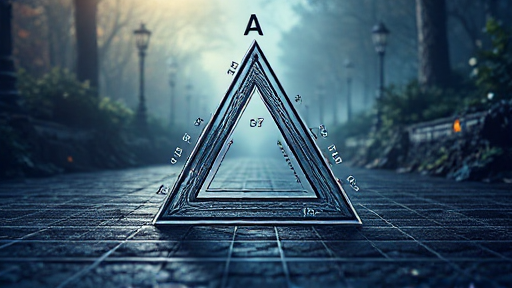

  0%|          | 0/4 [00:00<?, ?it/s]

Prompt:  René Descartes' portrait, surrounded by a faint outline of a coordinate plane with the triangle's vertices marked at A(1|1), B(5|1), and C(3|4). The title 'Cartesian Coordinates in Action' is written in bold, cursive font.
Function output: /home/ubuntu/math-video-generation-portfolio/thumbnails/project-1/descartes_with_triangle.png


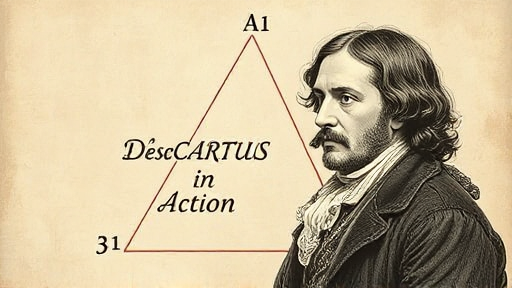

  0%|          | 0/4 [00:00<?, ?it/s]

Prompt:  A visual representation of the triangle as a geometric shape within a larger, intricate pattern inspired by sacred geometry. The vertices are labeled with their coordinates, and the background features subtle mathematical symbols or equations related to coordinate geometry.
Function output: /home/ubuntu/math-video-generation-portfolio/thumbnails/project-1/triangle_in_sacred_geometry.png


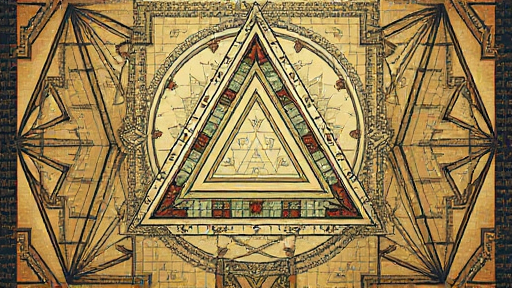

Step generate_images produced event ImagesGeneratedEvent
Running step evaluate_images
Thumbnail is suitable:  False
The image does not meet the evaluation criteria for a YouTube thumbnail. It lacks visual impact, technical quality, content alignment, and performance indicators.
Thumbnail is suitable:  False
The image does not meet the evaluation criteria for a YouTube thumbnail. It lacks visual impact, technical quality, content alignment, and performance indicators.
Thumbnail is suitable:  True
The image is suitable as a thumbnail because it meets all four evaluation criteria. It has high visual impact with its unique composition and color contrast, good technical quality with clear resolution and readability, aligns well with the content of the video by signaling educational value, and has strong performance indicators such as click-through potential and audience retention correlation.
Step evaluate_images produced event StopEvent
Pipeline-Visualizations/thumbnail_generation_last_exe

In [15]:
# Execute workflow
result = await thumbnail_generation_flow.run(task_description=task_description, video_plan=video_plan, num_thumbnails=3, settings=thumbnail_generation_settings)

# Save workflow execution path to HTML file
draw_most_recent_execution(thumbnail_generation_flow, filename="Pipeline-Visualizations/thumbnail_generation_last_execution.html")

In [16]:
# Print the resulting final video path (or last generated video path if final video generation failed)
print(result)

['/home/ubuntu/math-video-generation-portfolio/thumbnails/project-1/triangle_in_sacred_geometry.png']


In [17]:
part_3_results = {
    "video_path": result
}

with open("results/part_3_results.json", "w") as f:
    json.dump(part_3_results, f)